In [1]:
import geopandas as gpd

nfi = gpd.read_parquet('../data/processed_datasets/NFI_2003-2021_EPSG4326_FR.parquet').to_crs('epsg:32631')
#change the nfi class str 'Drought' to 'Drought-dieback'
nfi.loc[nfi['class'] == 'Drought', 'class'] = 'Drought-dieback'

In [3]:
nfi.to_csv('data.csv')

In [5]:
#zoom-in
from utils import pol_from_points, wrap_pol, make_square

bbox_epsg4326_scolyte = 3.702393,46.088472,6.163330,47.805776
pol_epsg32631_scolyte = make_square(wrap_pol(pol_from_points(bbox_epsg4326_scolyte), 4326, 32631))

bbox_epsg4326_biotic = -1.614990,41.979911,4.971313,44.816916
pol_epsg32631_biotic = make_square(wrap_pol(pol_from_points(bbox_epsg4326_biotic), 4326, 32631))

bbox_epsg4326_fire = 3.908386,42.765162,7.201538,44.182204
pol_epsg32631_fire = make_square(wrap_pol(pol_from_points(bbox_epsg4326_fire), 4326, 32631))

# Pere year

/Users/arthurcalvi/Venv/DiAtDaJo/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/arthurcalvi/Venv/DiAtDaJo/lib/python3.9/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/arthurcalvi/Venv/DiAtDaJo/lib/python3.9/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):
/Users/arthurcalvi/Venv/Di

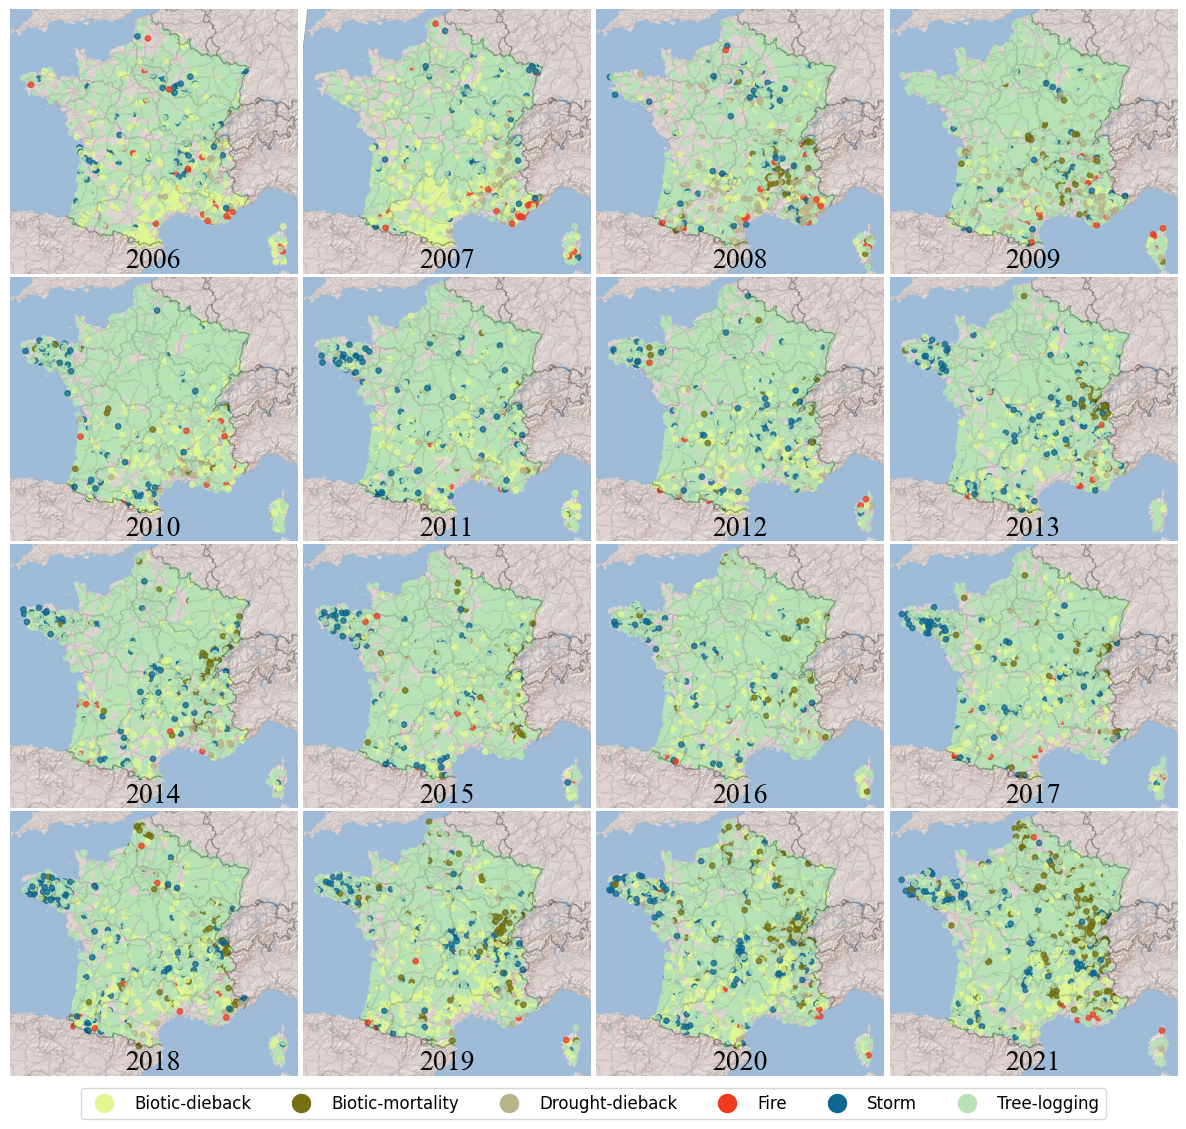

In [2]:
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.pyplot as plt
import contextily as cx
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.patches import Rectangle

all_classes = sorted(nfi['class'].unique())
colors = ['#e0f794', '#757012', '#b8b48a', '#f03b20', '#0c6791', '#b6e3b6']
# colors = ['#b6e3b6','#e0f794', '#0c6791', '#b8b48a', '#f03b20', '#757012']
cmap = ListedColormap(colors)
# Create the normalization based on your classes. The +1 ensures the last boundary is inclusive.
boundaries = list(range(len(all_classes) + 1))
norm = BoundaryNorm(boundaries, cmap.N, clip=True)

color_mapping = {cls: color for cls, color in zip(all_classes, colors)}

def plot_yearly_disturbances(gdf, year, ax, xlim, ylim, inset_ax=None, zoom_coords=None, rect_color=None):
    # Filter the GeoDataFrame for the specified year
    gdf_year = gdf[gdf['CAMPAGNE'] == year]
    gdf_year['color'] = gdf_year['class'].apply(lambda x: all_classes.index(x))

    # Plot the disturbances
    gdf_year.plot(ax=ax, column='color', cmap=cmap, norm=norm, alpha=0.75, markersize=15)
    source = cx.providers.Esri.WorldShadedRelief
    cx.add_basemap(ax, crs=nfi.crs, source=source, attribution=False)
    cx.add_basemap(ax, crs=nfi.crs, zoom=6, source=cx.providers.Stamen.TonerLines, attribution=False, alpha=0.5)
    #remove x, y axis details for clarity
    ax.set_axis_off()

    #add year at annotated text in the bottom left corner and with Times New Roman font
    ax.annotate(f"{year}", xy=(0.5, 0.05), xycoords='axes fraction', fontsize=20, color='black', ha='center', va='center', fontname='Times New Roman')

    
    # If zoom coordinates and an inset axis are provided, create the zoomed view on the inset axis
    if zoom_coords and inset_ax:
        x1, y1, x2, y2 = zoom_coords
        gdf_year.plot(ax=inset_ax, column='color', cmap=cmap, norm=norm)
        source = cx.providers.Esri.WorldShadedRelief
        cx.add_basemap(inset_ax, crs=nfi.crs, source=source, attribution=False)
        cx.add_basemap(inset_ax, crs=nfi.crs, source=cx.providers.Stamen.TonerLite, attribution=False, alpha=0.5)
        
        inset_ax.set_xlim(x1, x2)
        inset_ax.set_ylim(y1, y2)
        inset_ax.set_xticks([])
        inset_ax.set_yticks([])
        
        # Manually draw a rectangle on the main ax to indicate the zoomed area
        rect = Rectangle((x1, y1), x2-x1, y2-y1, fill=False, ec=rect_color, linestyle='--')
        ax.add_patch(rect)

         # Use the same color for the border of the inset_ax
        for spine in inset_ax.spines.values():
            spine.set_edgecolor(rect_color)
            spine.set_linewidth(2)

    if xlim is None or ylim is None:
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
    else:
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

    
    return xlim, ylim

#FIGURE
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 11), gridspec_kw={'width_ratios': [1, 1, 1, 1]})
# from matplotlib.gridspec import GridSpec
# fig = plt.figure(figsize=(20, 20))
# gs = GridSpec(4, 4, figure=fig, hspace=0.01, wspace=0.01)

#creates axes for each subplot
# axes = []
# for i in range(5):
#     for j in range(4):
#         axes.append(fig.add_subplot(gs[i, j]))


# Make sure your array is flattened to easily iterate over it
axes = axes.ravel()
for ax in axes:
    ax.set_aspect('equal')

# xmin1, ymin1, xmax1, ymax1 = pol_epsg32631_scolyte.bounds
# xmin2, ymin2, xmax2, ymax2 = pol_epsg32631_biotic.bounds
# xmin3, ymin3, xmax3, ymax3 = pol_epsg32631_fire.bounds

# # Define the colors for each year's rectangle and zoom
# zoom_colors = {
#     2019: '#757012',
#     2007: '#e0f794',
#     2021: '#f03b20'
# }

# # Define the coordinates to zoom into for each year
# zoom_coordinates = {
#     2019: [xmin1, ymin1, xmax1, ymax1],
#     2007: [xmin2, ymin2, xmax2, ymax2],
#     2021: [xmin3, ymin3, xmax3, ymax3]
# }

# # Define which inset axes correspond to which year
# inset_axes_mapping = {
#     2019: axes[17],
#     2007: axes[18],
#     2021: axes[19]
# }

xlim, ylim = None, None
# Iterate over years and axes together
for year, ax in zip(range(2006, 2022), axes):
    # inset_ax = inset_axes_mapping.get(year, None)
    # coords = zoom_coordinates.get(year, None)
    # color = zoom_colors.get(year, '0.5')
    xlim, ylim = plot_yearly_disturbances(nfi, year, ax, xlim, ylim)

# # Create a legend for the disturbance classes
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label=cls, markersize=15, markerfacecolor=color_mapping[cls]) for cls in color_mapping]
fig.legend(handles=legend_elements, loc='lower center', ncol=6, fontsize=12, bbox_to_anchor=(0.5, -0.03))

# Tight layout often produces better results when having multiple subplots
# plt.tight_layout()

fig.tight_layout()
fig.subplots_adjust(wspace=0.01, hspace=0.01) 
plt.show()




In [71]:
#save figure
dpi = 100
fig.savefig(f'../figures/NFI_2006-2021_EPSG32631_FR_dpi{dpi}.png', dpi=dpi, bbox_inches='tight')

# class and year



In [5]:
#generate a Shapely polygon from xlim and ylim :
from utils import pol_from_points 
boundaries = pol_from_points((*xlim, *ylim)) 

#create a dataframe from boundaries 
import pandas as pd
df = pd.DataFrame({'geometry': boundaries}, index=[0])
df = gpd.GeoDataFrame(df, crs='epsg:32631')

In [41]:
import pandas as pd
def valid_years(start, end, s, e):
    if ((not pd.isnull(start)) and (start < e)) or ((not pd.isnull(end)) and (end > s)):
        return True 
    else :
        return False

In [51]:
all_classes

['Biotic-dieback',
 'Biotic-mortality',
 'Drought-dieback',
 'Fire',
 'Storm',
 'Tree-logging']

/Users/arthurcalvi/Venv/DiAtDaJo/lib/python3.9/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/arthurcalvi/Venv/DiAtDaJo/lib/python3.9/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/arthurcalvi/Venv/DiAtDaJo/lib/python3.9/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

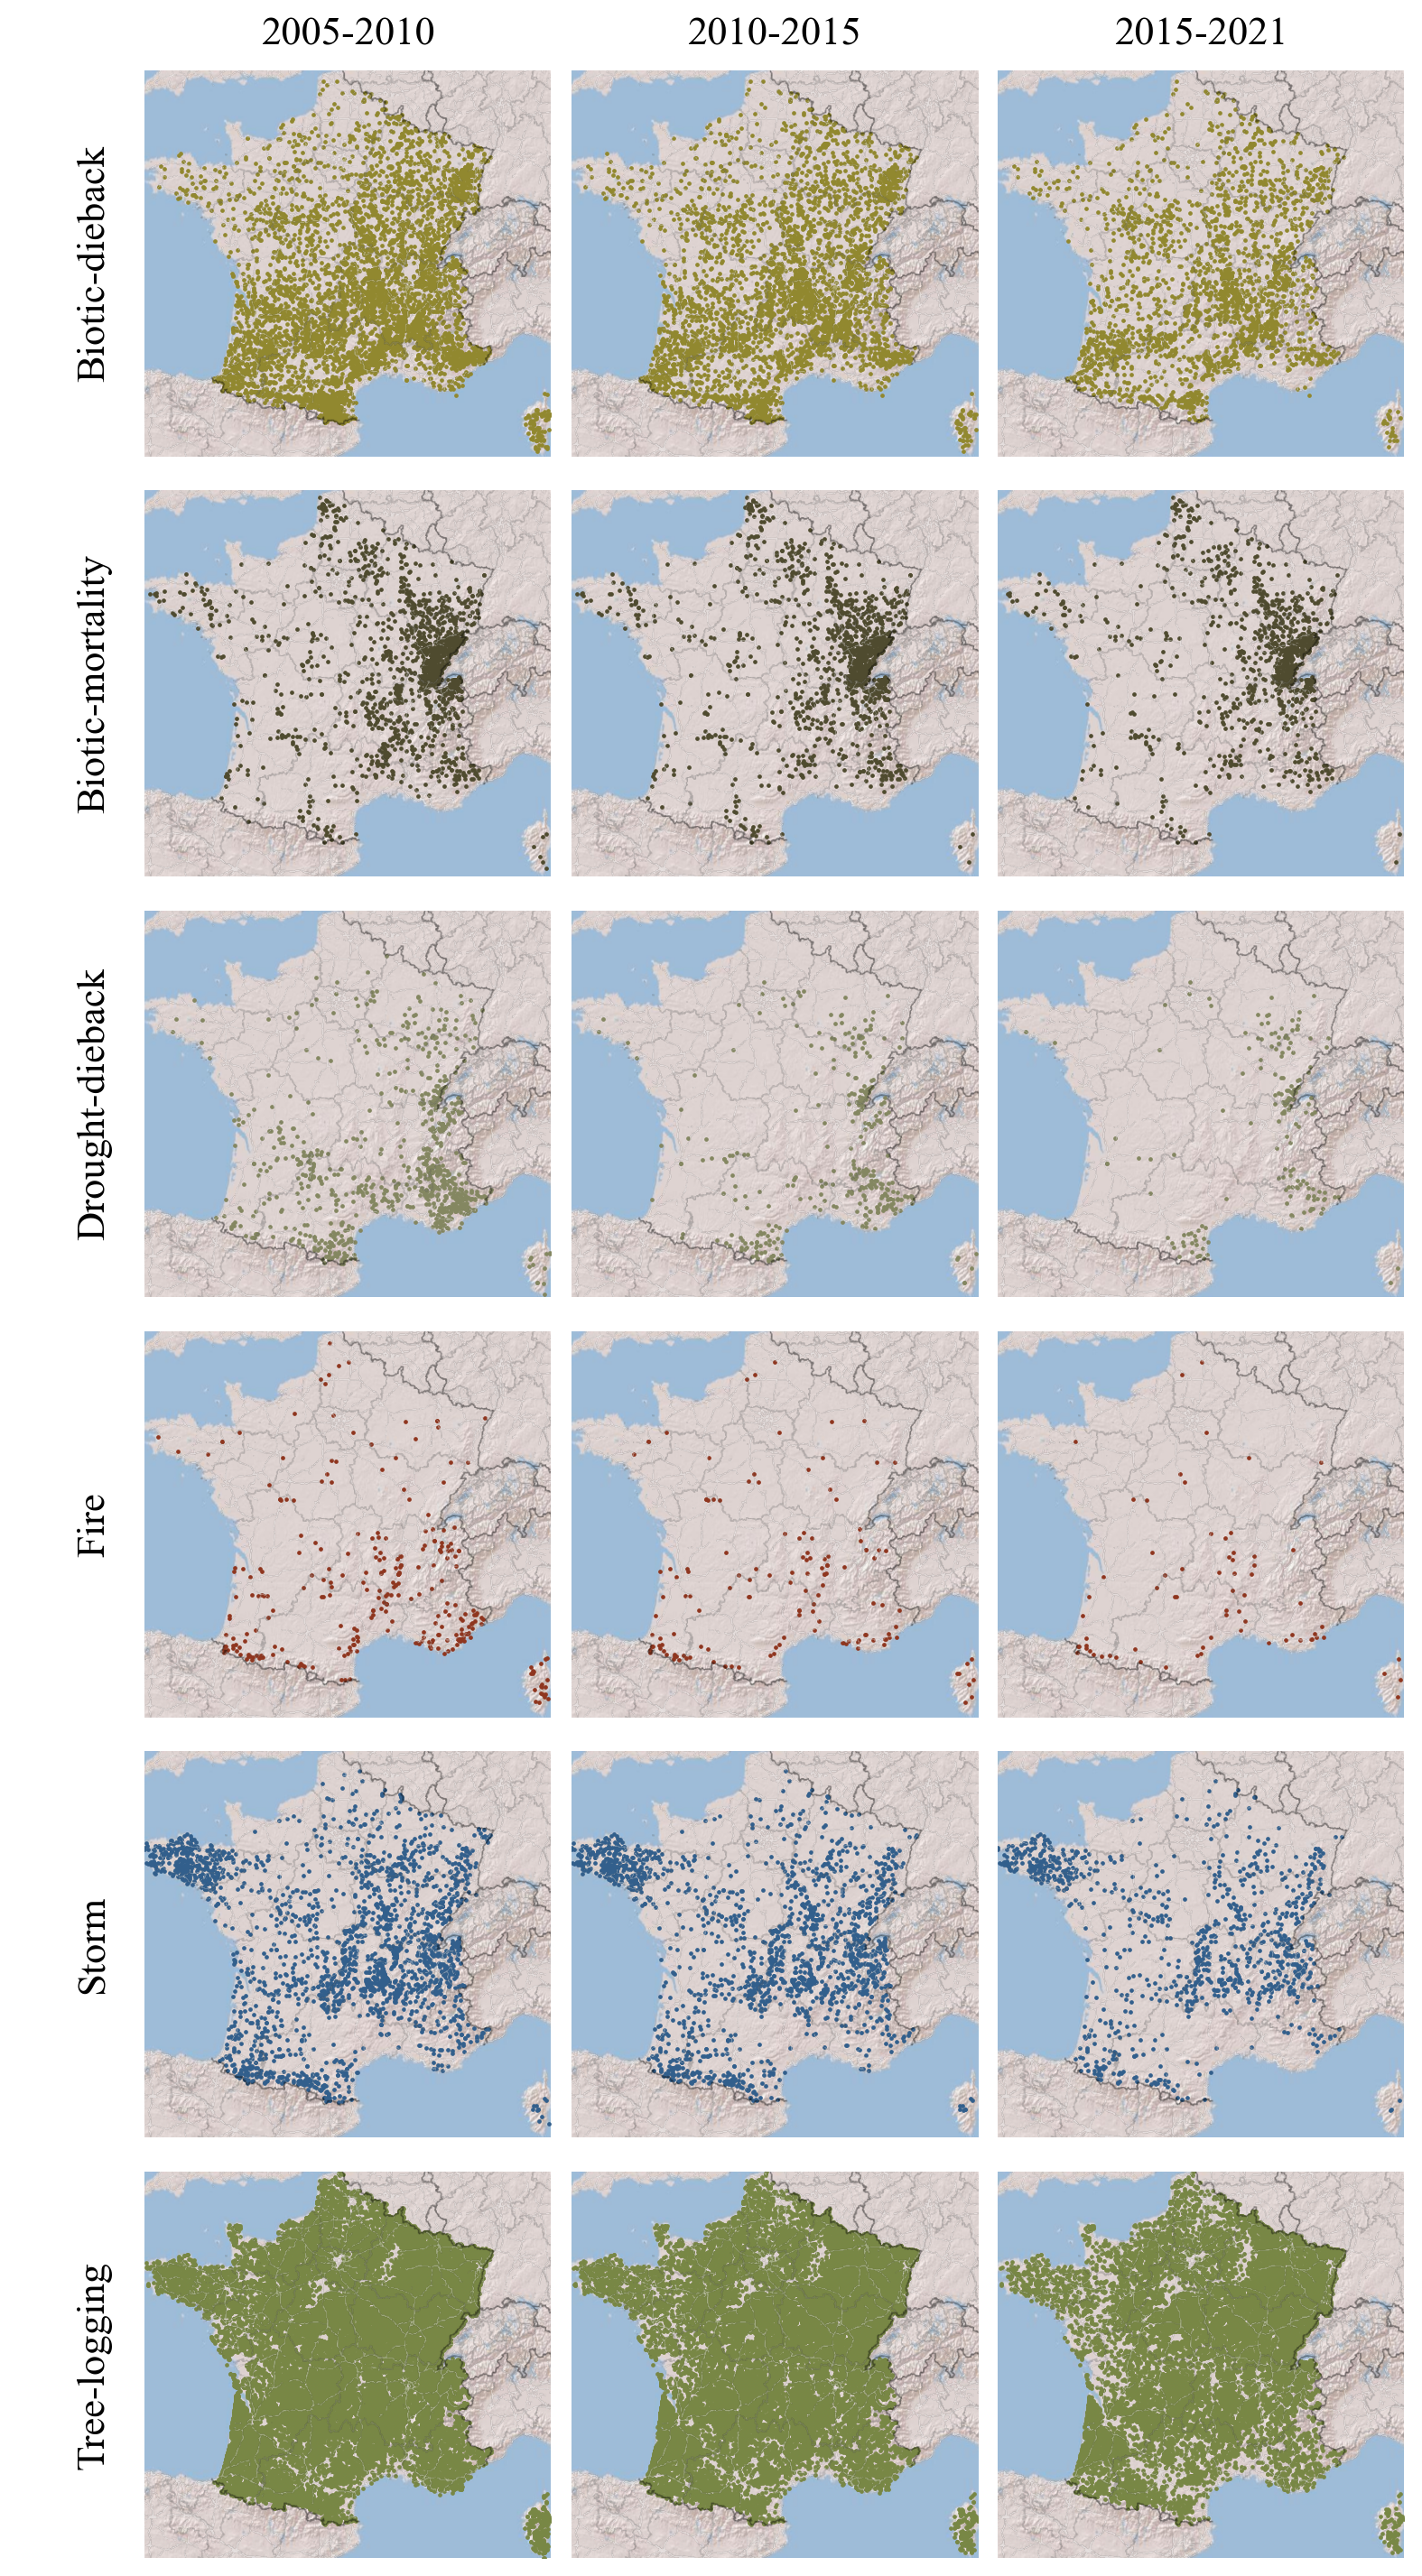

In [75]:
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.pyplot as plt
import contextily as cx
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.patches import Rectangle

all_classes = sorted(nfi['class'].unique())
# colors = ['#e0f794', '#757012', '#b8b48a', '#f03b20', '#0c6791', '#b6e3b6']
colors = ['#91882f','#4f4b2f', '#848761', '#8f361f', '#325f8c', '#788745']
years = [(2005, 2010), (2010, 2015), (2015, 2021)]

cmap = ListedColormap(colors)
# Create the normalization based on your classes. The +1 ensures the last boundary is inclusive.
boundaries = list(range(len(all_classes) + 1))
norm = BoundaryNorm(boundaries, cmap.N, clip=True)

color_mapping = {cls: color for cls, color in zip(all_classes, colors)}

def plot_yearly_class(gdf, s, e, class_, ax, xlim, ylim, color):
    # Filter the GeoDataFrame for the specified year
    data = gdf[ (gdf['class'] == class_) ]
    data['valid'] = data.apply(lambda x: valid_years(x['start_date'].year, x['end_date'].year, s, e), axis=1)
    data = data[data['valid'] == True]
    data['color'] = data['class'].apply(lambda x: all_classes.index(x))

    # Plot the disturbances
    data.plot(ax=ax, color=color, alpha=1, markersize=0.5)
    df.plot(ax=ax, color='none', edgecolor='none', linewidth=0)
    source = cx.providers.Esri.WorldShadedRelief
    cx.add_basemap(ax, crs=nfi.crs, zoom=6, source=source, attribution=False)
    cx.add_basemap(ax, crs=nfi.crs, zoom=6, source=cx.providers.Stamen.TonerLines, attribution=False, alpha=0.5)
    #remove x, y axis details for clarity
    ax.set_axis_off()


    if xlim is None or ylim is None:
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
    else:
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

    
    return xlim, ylim

#FIGURE
import matplotlib.gridspec as gridspec

# Create a 4x6 grid of subplots
fig = plt.figure(figsize=(9, 18), dpi=200)  # Adjust figsize as needed

# Define the grid
gs = gridspec.GridSpec(nrows=6, ncols=3, hspace=0.05, wspace=0.05)  

xlim = (nfi.bounds.minx.min(), nfi.bounds.maxx.max())
ylim = (nfi.bounds.miny.min(), nfi.bounds.maxy.max())
# Iterate over years and axes together
for j, (c,row) in enumerate(zip(all_classes, axes)):

    for i, ((s,e), col) in enumerate(zip(years,row)):
        
        ax = fig.add_subplot(gs[j, i])
        if i == 0:
            ax.annotate(c, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 15, 0),
                xycoords=ax.yaxis.label, textcoords='offset points', ha='right', va='center', rotation=90, fontsize=16, color='black', fontname='Times New Roman')
        if j == 0:
            ax.annotate(f'{s}-{e}', xy=(0.5, 1), xytext=(0, 10),
                xycoords='axes fraction', textcoords='offset points', ha='center', va='baseline', fontsize=16, color='black', fontname='Times New Roman')
        xlim, ylim = plot_yearly_class(nfi, s, e, c, ax, xlim, ylim, colors[int(all_classes.index(c))])

fig.tight_layout()
fig.subplots_adjust(wspace=0.05, hspace=0.05) 
plt.show()




In [74]:
dpi=200
fig.savefig(f'../figures/NFI_2005-2021_EPSG32631_FR_dpi{dpi}.png', dpi=dpi, bbox_inches='tight')

# histogram2d

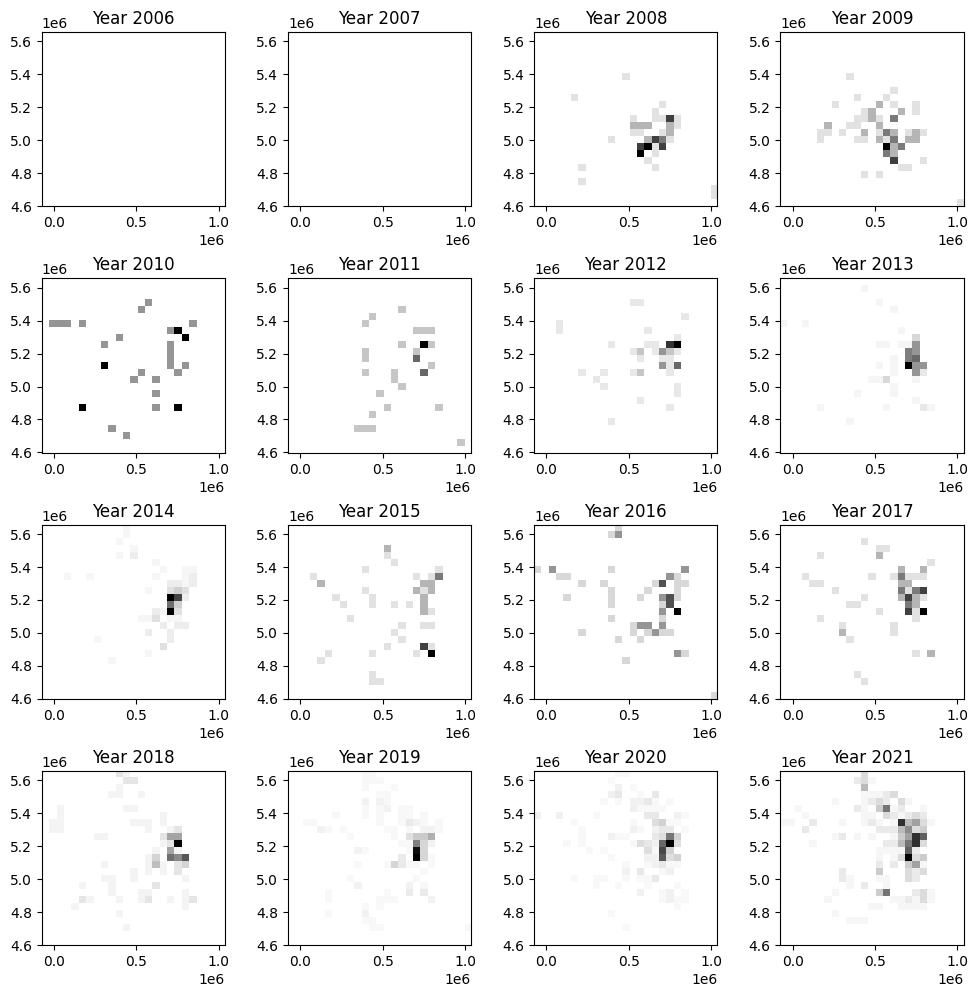

In [44]:
import numpy as np
import matplotlib.pyplot as plt

years = sorted(nfi['CAMPAGNE'].unique())

fig, axes = plt.subplots(4, 4, figsize=(10, 10))  # Adjust the grid size as needed

for year, ax in zip(range(2006, 2022), axes.ravel()):
    year_data = nfi[nfi['CAMPAGNE'] == year]
    
    # Define the extent (boundary) for the plots
    extent = [nfi['geometry'].x.min(), nfi['geometry'].x.max(), nfi['geometry'].y.min(), nfi['geometry'].y.max()]
    
    cmap = ['Blues', 'Reds', 'Greens', 'Oranges', 'Purples', 'Greys']
    for i,cls in enumerate(nfi['class'].unique()):
        class_data = year_data[year_data['class'] == cls]
        
        # Compute the density
        H, xedges, yedges = np.histogram2d(class_data['geometry'].x, class_data['geometry'].y, bins=25, range=[[extent[0], extent[1]], [extent[2], extent[3]]])
        
        # Plot the density (using a transparent colormap)
        ax.imshow(H.T, origin='lower', extent=extent, alpha=1, cmap=cmap[i])  # Choose an appropriate colormap
        
    ax.set_title(f"Year {year}")

plt.tight_layout()
plt.show()


# Code interpreter solution

In [2]:
from shapely import wkt
import pandas as pd
import geopandas as gpd


# Load the CSV data
nfi_csv = pd.read_csv('data.csv')
#change the nfi class str 'Drought' to 'Drought-dieback'
nfi_csv.loc[nfi_csv['class'] == 'Drought', 'class'] = 'Drought-dieback'
# Parse the 'geometry' column to extract longitude and latitude
nfi_csv['geometry'] = nfi_csv['geometry'].apply(wkt.loads)
nfi_csv['longitude'] = nfi_csv['geometry'].apply(lambda geom: geom.x)
nfi_csv['latitude'] = nfi_csv['geometry'].apply(lambda geom: geom.y)

# Parse 'start_date' and 'end_date' to datetime format
nfi_csv['start_date'] = pd.to_datetime(nfi_csv['start_date'], errors='coerce')
nfi_csv['end_date'] = pd.to_datetime(nfi_csv['end_date'], errors='coerce')

# Extract year from the start_date
nfi_csv['year'] =  (nfi_csv['end_date'].dt.year - 5 / 2)

# Set class names
class_names = nfi_csv['class'].unique()

# Load the data with GeoPandas
gdf = gpd.GeoDataFrame(
    nfi_csv, 
    geometry=gpd.points_from_xy(nfi_csv.longitude, nfi_csv.latitude),
    crs="EPSG:32631"  # Set the CRS to 'epsg:32631'
)



In [3]:
from matplotlib.ticker import MultipleLocator, FuncFormatter
import math

# Define a function to convert Web Mercator to lat/lon
def web_mercator_to_lat_lon(val, pos=None, is_lat=True):
    if is_lat:
        return "{:.2f}°".format(math.degrees(2 * math.atan(math.exp(val / 6378137.0)) - math.pi/2))
    else:
        return "{:.2f}°".format(val / (6378137.0) * 57.2957795)


/Users/arthurcalvi/Venv/DiAtDaJo/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/arthurcalvi/Venv/DiAtDaJo/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


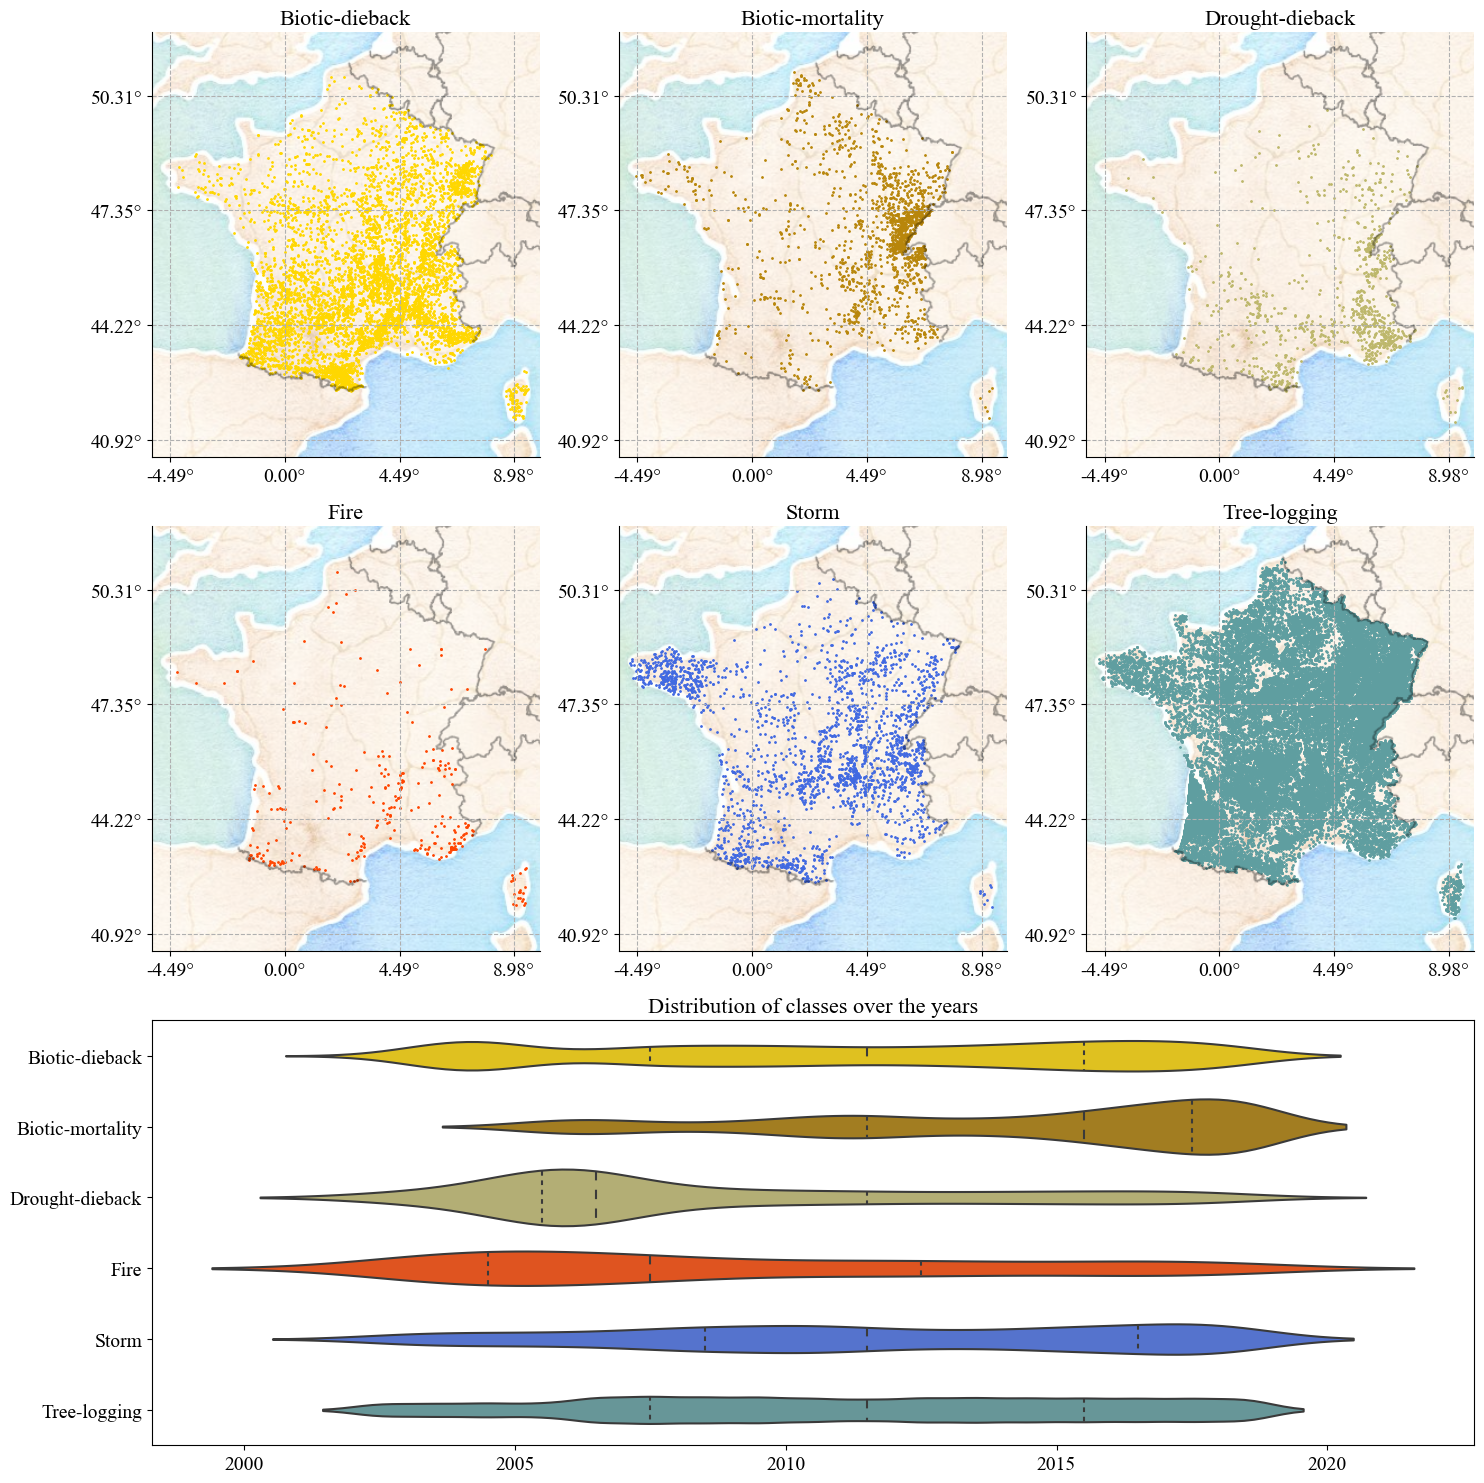

In [4]:
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as cx
from utils import pol_from_points
from matplotlib.ticker import MultipleLocator, FuncFormatter
import math

# Set global font to Times New Roman
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

# Set global font size
plt.rcParams['font.size'] = 12  # Adjust as needed

# Additional font size settings
plt.rcParams['axes.labelsize'] = 14  # Font size for x and y labels
plt.rcParams['axes.titlesize'] = 16  # Font size for subplot titles
plt.rcParams['xtick.labelsize'] = 14  # Font size for x tick labels
plt.rcParams['ytick.labelsize'] = 14  # Font size for y tick labels


# Setup the figure and axes using GridSpec
fig = plt.figure(figsize=(15, 15))
gs = GridSpec(3, 3, figure=fig)

# Define colors for each class
custom_color_mapping = {
    'Fire': 'orangered',
    'Storm': 'royalblue',
    'Biotic-dieback': 'gold',
    'Biotic-mortality': 'darkgoldenrod',  # Yellow-brown
    'Drought-dieback': 'darkkhaki',
    'Tree-logging': 'cadetblue'  # Light blue/grey
}

gdf_web_mercator = gdf.to_crs(epsg=3857)
minx, miny, maxx, maxy = gdf_web_mercator.geometry.buffer(50000).total_bounds
#build GeoDataFrame from the bounds
df = gpd.GeoDataFrame({'geometry': pol_from_points((minx, miny, maxx, maxy))}, index=[0], crs='epsg:3857')

# Plot point clouds for each class in the first two rows
for idx, class_name in enumerate(sorted(class_names)):
    row = idx // 3
    col = idx % 3
    ax = fig.add_subplot(gs[row, col])
    
    df.plot(ax=ax, color='none', edgecolor='none', linewidth=0)
    gdf_web_mercator[gdf_web_mercator['class'] == class_name].plot(ax=ax, color=custom_color_mapping[class_name], markersize=1, alpha=1)
    
    # Adding basemap with contextily
    # cx.add_basemap(ax, crs=gdf_web_mercator.crs.to_string(), attribution=False, source=cx.providers.Esri.WorldShadedRelief)
    cx.add_basemap(ax, crs=df.crs.to_string(), attribution=False, source=cx.providers.Stamen.Watercolor, zoom=5, alpha=.4)
    cx.add_basemap(ax, crs=df.crs.to_string(), attribution=False, source=cx.providers.Stamen.TonerLines, zoom=5, alpha=0.4)
    # cx.add_basemap(ax, crs=df.crs.to_string(), attribution=False, source=cx.providers.Stamen.TonerLabels, zoom=5, alpha=0.4)
    ax.set_title(class_name)
    # ax.set_xlabel('Longitude')
    # ax.set_ylabel('Latitude')
    ax.axis('equal')
    
    ax.grid(True, linestyle='--')  # Add grid

    # Setting the same extents for all plots
    ax.set_xlim((minx, maxx))
    ax.set_ylim((miny, maxy))

    

    if row < 2:
        
        # Using MultipleLocator to set tick locations
        ax.xaxis.set_major_locator(MultipleLocator(0.5 * 10**6))
        ax.yaxis.set_major_locator(MultipleLocator(0.5 * 10**6))

        # Using FuncFormatter to convert tick labels to lat/lon
        ax.xaxis.set_major_formatter(FuncFormatter(lambda val, pos: web_mercator_to_lat_lon(val, pos, is_lat=False)))
        ax.yaxis.set_major_formatter(FuncFormatter(web_mercator_to_lat_lon))
        
        # # ax.set_yticks([round(coord, -5) for coord in ax.get_yticks()])
        # ax.set_yticklabels([f"{coord/10**6:.1f}°" for coord in ax.get_yticks()], va="center")
        # # ax.set_xticks([round(coord, -5) for coord in ax.get_xticks()])
        # ax.set_xticklabels([f"{coord/10**6:.1f}°" for coord in ax.get_xticks()])
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)


# Plot violin plots in the third row spanning all columns with normalized width
ax_violin = fig.add_subplot(gs[2, :])
sns.violinplot(x='year', y='class', data=gdf, ax=ax_violin, order=sorted(class_names),
               palette=custom_color_mapping, inner="quart", density_norm='width')
ax_violin.set_title('Distribution of classes over the years')
ax_violin.set_ylabel(None)
ax_violin.set_xlabel(None)
plt.tight_layout()
plt.show()


In [142]:
dpi = 200 
fig.savefig(f'../figures/NFI_2006-2021_EPSG3857_FR_dpi{dpi}.png', dpi=dpi, bbox_inches='tight')

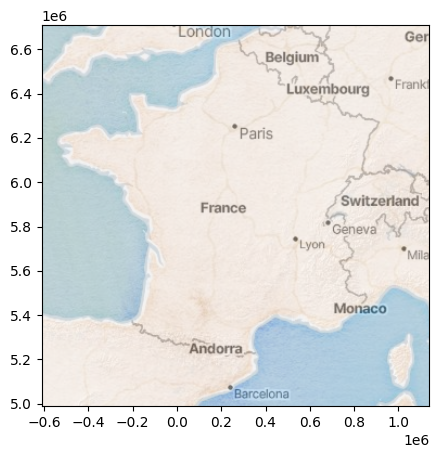

In [114]:
fig, ax = plt.subplots(figsize=(5, 5))

df.plot(ax=ax, color=None, edgecolor='none', linewidth=0, alpha=0)
cx.add_basemap(ax, crs=df.crs.to_string(), attribution=False, source=cx.providers.Stamen.Watercolor, zoom=5)
cx.add_basemap(ax, crs=df.crs.to_string(), attribution=False, source=cx.providers.Stamen.TonerLite, zoom=5, alpha=0.5)